In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the datasets
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Convert Date columns to datetime format
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')

# Extract Quarter information to align the datasets
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge datasets on 'Quarter'
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')

# Select relevant columns
merged_data_cleaned = merged_data[['Quarterly_GDP'] + 
                                   [col for col in bank_data.columns if col not in ['Quarter-Year', 'quarter', 'year', 'Date', 'Quarter']]]

# Convert columns to numeric, handling non-numeric entries
for col in merged_data_cleaned.columns:
    merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')

# Drop columns with more than 50% missing values
threshold = len(merged_data_cleaned) * 0.5
cleaned_data = merged_data_cleaned.dropna(thresh=threshold, axis=1)

# Impute remaining missing values with median
imputer = SimpleImputer(strategy='median')
cleaned_data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

# Separate features and target variable
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)  # Limited to reduce training time
lr_model = LinearRegression()

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
lr_mse = mean_squared_error(y_test, lr_preds)

rf_r2 = r2_score(y_test, rf_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
lr_r2 = r2_score(y_test, lr_preds)

# Model performance results
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Linear Regression'],
    'MSE': [rf_mse, xgb_mse, lr_mse],
    'R2 Score': [rf_r2, xgb_r2, lr_r2]
})

print(model_performance)


               Model           MSE  R2 Score
0      Random Forest  8.375993e+10  0.572137
1            XGBoost  1.042395e+11  0.467523
2  Linear Regression  8.356165e+10  0.573150


C:\Users\Vinh\AppData\Local\Temp\ipykernel_8992\2747916600.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')


In [3]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Load and prepare the data
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Convert Date columns to datetime format and align quarters
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge datasets
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')
merged_data_cleaned = merged_data[['Quarterly_GDP'] + 
                                   [col for col in bank_data.columns if col not in ['Quarter-Year', 'quarter', 'year', 'Date', 'Quarter']]]
for col in merged_data_cleaned.columns:
    merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')

# Drop columns with many missing values and impute remaining missing values
threshold = len(merged_data_cleaned) * 0.5
cleaned_data = merged_data_cleaned.dropna(thresh=threshold, axis=1)
imputer = SimpleImputer(strategy='median')
cleaned_data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

# Split data into training and test sets
train_size = int(len(cleaned_data_imputed) * 0.8)
train_data, test_data = cleaned_data_imputed.iloc[:train_size], cleaned_data_imputed.iloc[train_size:]

# Separate target and exogenous variables
train_endog = train_data['Quarterly_GDP']
train_exog = train_data.drop(columns=['Quarterly_GDP'])
test_endog = test_data['Quarterly_GDP']
test_exog = test_data.drop(columns=['Quarterly_GDP'])

# Define SARIMAX parameters and train the model
sarimax_order = (1, 1, 1)        # ARIMA(p, d, q)
seasonal_order = (1, 1, 1, 4)    # Quarterly seasonality (P, D, Q, s)

sarimax_model = SARIMAX(train_endog, exog=train_exog, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast and calculate MAPE
sarimax_forecast = sarimax_result.predict(start=len(train_data), end=len(cleaned_data_imputed)-1, exog=test_exog)
sarimax_mape = mean_absolute_percentage_error(test_endog, sarimax_forecast)

print(f"SARIMAX MAPE: {sarimax_mape:.4%}")


C:\Users\Vinh\AppData\Local\Temp\ipykernel_8992\2905893287.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMAX MAPE: 6.9440%


In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Ensure data preparation is consistent
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Refined XGBoost model configuration
xgb_model_refined = XGBRegressor(
    n_estimators=100,       # Slightly increased tree count for better accuracy
    max_depth=4,            # Depth increased to allow model complexity
    learning_rate=0.05,     # Lowered to capture finer patterns
    subsample=0.9,          # 90% of data per tree for robustness
    colsample_bytree=0.9,   # 90% of features per tree
    random_state=42
)

# Train and calculate MAPE
xgb_model_refined.fit(X_train, y_train)
xgb_preds_refined = xgb_model_refined.predict(X_test)
xgb_mape_refined = mean_absolute_percentage_error(y_test, xgb_preds_refined)

print(f"Refined XGBoost MAPE: {xgb_mape_refined:.4%}")


Refined XGBoost MAPE: 16.9883%


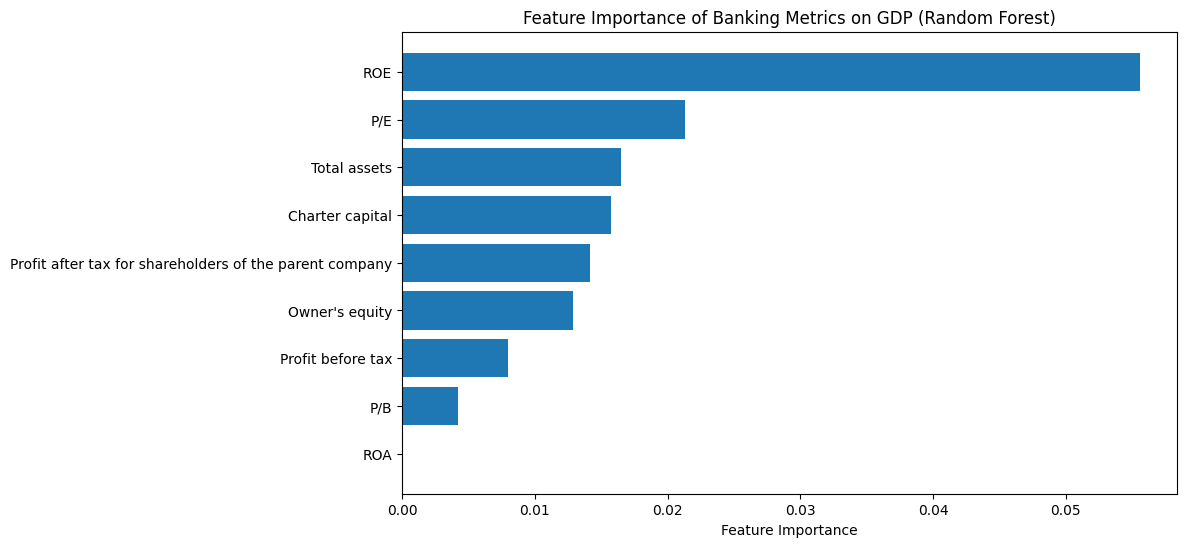

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Fit the Random Forest model again (if necessary)
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)

# Extract feature importances and feature names
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance and exclude the top two (% and %.1)
sorted_idx = np.argsort(feature_importances)[::-1][2:]  # Skip the top two features
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot the feature importances excluding the top two
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, align='center')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Banking Metrics on GDP (Random Forest)")
plt.gca().invert_yaxis()  # Display most important features at the top
plt.show()


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Load the dataset
# Assuming the dataset is loaded and cleaned as 'cleaned_data_imputed'

# Drop irrelevant columns `%` and `%.1` from the feature set
cleaned_data_imputed = cleaned_data_imputed.drop(columns=['%', '%.1'], errors='ignore')

# Separate features and target variable
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and calculate MAPE and RMSE
rf_preds = rf_model.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest MAPE (after removing % and %.1): {rf_mape:.4%}")
print(f"Random Forest RMSE (after removing % and %.1): {rf_rmse:.2f}")


Random Forest MAPE (after removing % and %.1): 9.4273%
Random Forest RMSE (after removing % and %.1): 182799.87


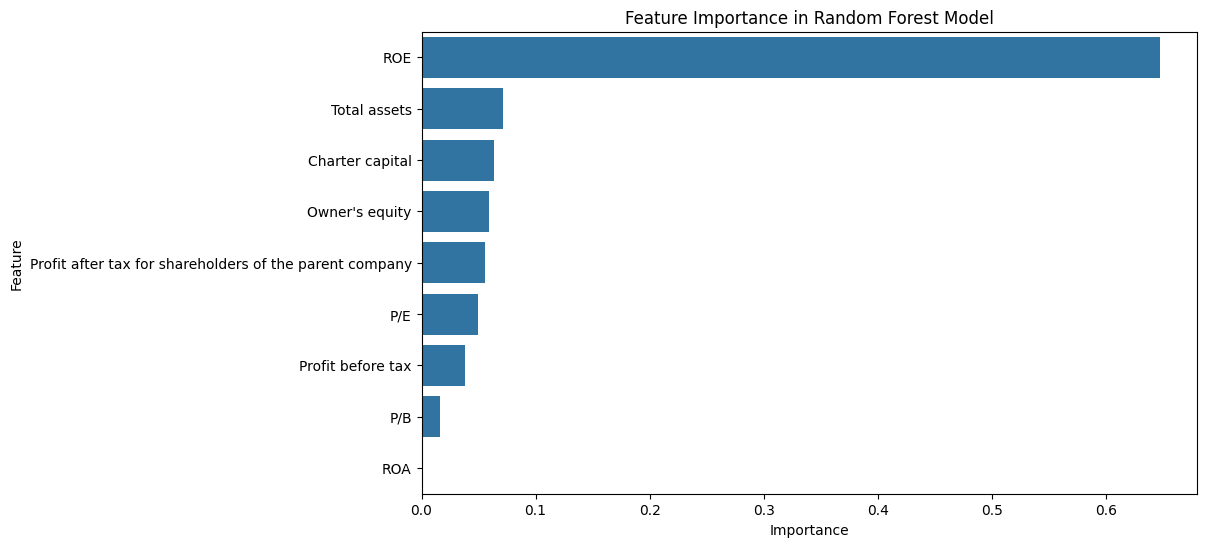

In [8]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [9]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import pandas as pd

# Step 1: Log transform for ROE to reduce dominance
X['ROE_log'] = np.log1p(X['ROE'])  # Use log(1 + ROE) to avoid log(0) issues
X = X.drop(columns=['ROE'])  # Drop the original ROE to avoid redundancy

# Step 2: Generate interaction and polynomial features (degree 2 for simplicity)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Get the names for the generated polynomial and interaction features
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)

# Step 3: Concatenate the original and polynomial features
X_final = pd.concat([X, X_poly_df], axis=1)

# Step 4: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert scaled data back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_final.columns, index=X_final.index)

# Re-run the train/test split with the new features and scaling applied
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Train and evaluate the model again
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest MAPE (after feature engineering and scaling): {rf_mape:.4%}")
print(f"Random Forest RMSE (after feature engineering and scaling): {rf_rmse:.2f}")


Random Forest MAPE (after feature engineering and scaling): 8.7211%
Random Forest RMSE (after feature engineering and scaling): 171534.06


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


In [11]:
# Test different SARIMAX configurations manually
sarimax_model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
sarimax_preds = sarimax_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=False)


f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predi

In [12]:
# Adjust weights to find the optimal combination
best_mape = float('inf')
best_weights = (0.6, 0.4)

for rf_weight in [0.5, 0.6, 0.7, 0.8]:
    sarimax_weight = 1 - rf_weight
    ensemble_preds = rf_weight * rf_preds + sarimax_weight * sarimax_preds
    ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)
    if ensemble_mape < best_mape:
        best_mape = ensemble_mape
        best_weights = (rf_weight, sarimax_weight)

print(f"Optimal Weights: Random Forest = {best_weights[0]}, SARIMAX = {best_weights[1]}")
print(f"Ensemble MAPE with Optimal Weights: {best_mape:.4%}")


Optimal Weights: Random Forest = 0.8, SARIMAX = 0.19999999999999996
Ensemble MAPE with Optimal Weights: 13.7488%


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and perform grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

# Use the best estimator from the grid search
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)

print("Optimized Random Forest MAPE:", mean_absolute_percentage_error(y_test, rf_preds))


Optimized Random Forest MAPE: 0.09742883475453182


In [14]:
# Final ensemble with optimized weights
ensemble_preds = best_weights[0] * rf_preds + best_weights[1] * sarimax_preds
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))

print(f"Final Ensemble MAPE: {ensemble_mape:.4%}")
print(f"Final Ensemble RMSE: {ensemble_rmse:.2f}")


Final Ensemble MAPE: 14.3783%
Final Ensemble RMSE: 273017.29


In [15]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Custom wrapper for SARIMAX
class SARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None  # Placeholder for the fitted SARIMAX model

    def fit(self, X, y):
        # SARIMAX requires a univariate series as input, so ignore X and fit on y
        self.model_ = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order).fit(disp=False)
        return self

    def predict(self, X):
        # Generate predictions for the same length as X
        pred_start = len(self.model_.model.endog)
        pred_end = pred_start + len(X) - 1
        return self.model_.predict(start=pred_start, end=pred_end, dynamic=False)

# Initialize the SARIMAX regressor with the desired parameters
sarimax_regressor = SARIMAXRegressor(order=(2, 1, 2), seasonal_order=(1, 1, 1, 4))

# Now define the stacking regressor with the custom SARIMAX wrapper and Random Forest
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define base models
base_models = [
    ('rf', best_rf),                      # Optimized Random Forest model
    ('sarimax', sarimax_regressor)        # Wrapped SARIMAX model
]

# Define the meta-model (Linear Regression)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=3
)

# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
stacking_preds = stacking_model.predict(X_test)

# Evaluate the stacking model
stacking_mape = mean_absolute_percentage_error(y_test, stacking_preds)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))

print(f"Stacking Model MAPE: {stacking_mape:.4%}")
print(f"Stacking Model RMSE: {stacking_rmse:.2f}")


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
f:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Stacking Model MAPE: 9.5279%
Stacking Model RMSE: 199779.55


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


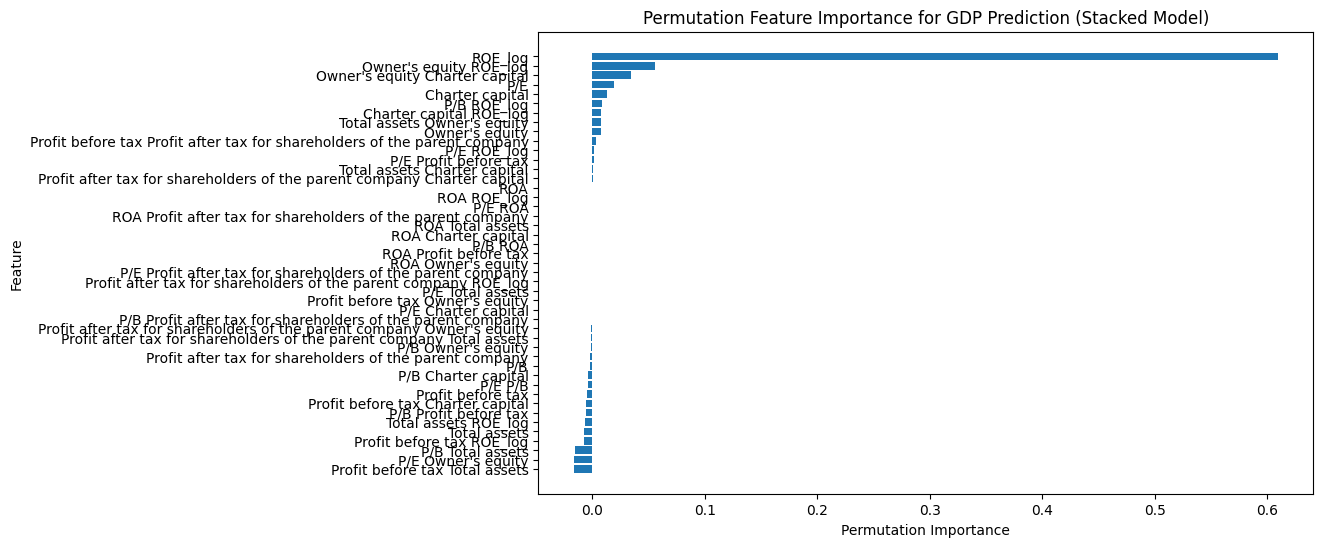

In [33]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance for the stacked model
perm_importance = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)

# Extract the feature importances and feature names
importance_scores = perm_importance.importances_mean
feature_names = X_test.columns

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the permutation importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance for GDP Prediction (Stacked Model)')
plt.gca().invert_yaxis()
plt.show()


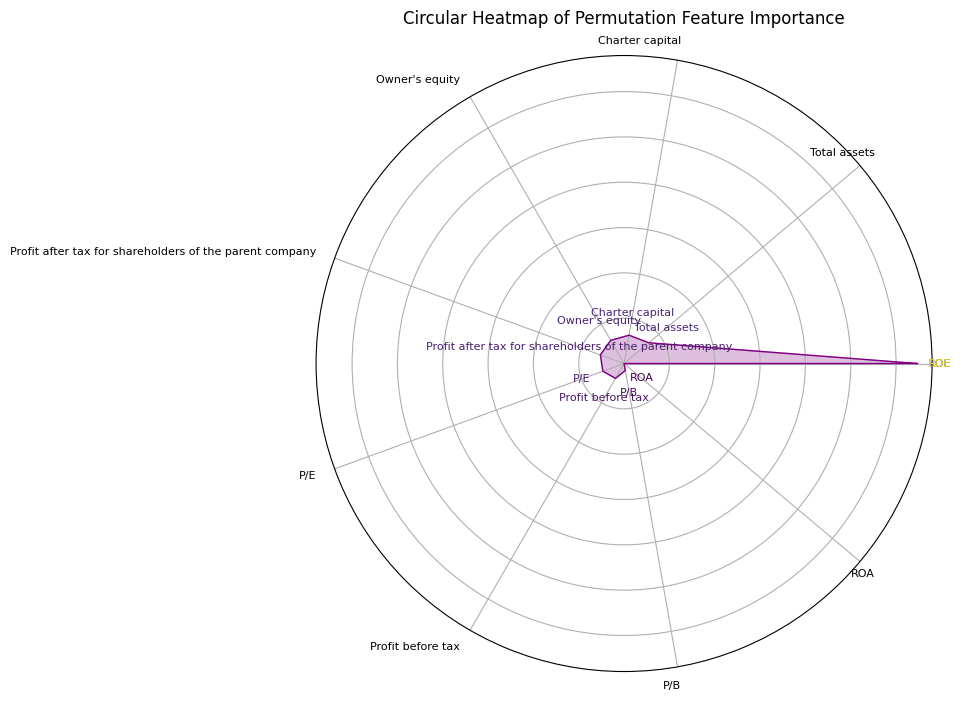

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

# Assuming feature_importance_df is already sorted and contains 'Feature' and 'Importance'

# Number of features
num_features = len(feature_importance_df)

# Set up the figure and polar axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Set the angles for each feature in radians
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]
feature_importances = feature_importance_df['Importance'].values
feature_importances = np.append(feature_importances, feature_importances[0])  # Close the loop

# Normalize the feature importances for color mapping
norm = plt.Normalize(min(feature_importances), max(feature_importances))
colors = cm.viridis(norm(feature_importances))

# Plot each feature as a point in the polar plot
ax.plot(angles, feature_importances, color='purple', linewidth=1, linestyle='solid')
ax.fill(angles, feature_importances, color='purple', alpha=0.25)

# Set the labels for each angle
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_importance_df['Feature'], fontsize=8, rotation=45, ha='right')

# Color each feature label based on its importance
for i, (angle, color) in enumerate(zip(angles[:-1], colors)):
    ax.text(angle, feature_importances[i] + 0.05, feature_importance_df['Feature'].iloc[i],
            ha='center', va='center', color=color, fontsize=8)

# Add title
plt.title('Circular Heatmap of Permutation Feature Importance', va='bottom')

plt.show()
